In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('ver1.csv', index_col=['id'])
display(df.columns)
df.drop(columns=['production_countries', 'production_companies', 'genres', 'release_date'], inplace=True)

col_norm = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity_norm']

df_norm = df
# df_norm[col_norm] = (df_norm[col_norm] - df_norm[col_norm].mean()) / df_norm[col_norm].std()
df_norm = (df_norm - df_norm.mean()) / df_norm.std()

display(len(df_norm.columns), len(df_norm))

X_train, X_test = train_test_split(df_norm, test_size = 0.2, random_state=1)

X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)

Index(['budget', 'genres', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity_norm',
       'year', 'month', 'date', 'quarter', 'others', 'en', 'fr', 'ru', 'es',
       'hi', 'ja', 'it', 'ko', 'cn', 'zh'],
      dtype='object')

23

3169

In [3]:
kmeans = KMeans(n_clusters=10)
cluster_predict = kmeans.fit_predict(X_train)
display(X_train, cluster_predict)

,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,popularity_norm,year,month,date,quarter,others,en,fr,ru,es,hi,ja,it,ko,cn,zh
id,,,,,,,,,,,,,,,,,,,,,,,
12160,0.487400,-0.130401,-0.430745,-0.525168,3.818361,0.213421,-0.557498,-0.430745,-0.582537,-0.293777,1.004123,-0.581184,-0.097745,0.199213,-0.087343,-0.043547,-0.068952,-0.043547,-0.06417,-0.039746,-0.039746,-0.039746,-0.061643
1024,-0.815018,-0.130401,-0.571277,-0.642606,-0.567772,0.790005,-0.492792,-0.571277,-0.582537,0.597397,-1.599471,0.336033,-0.097745,0.199213,-0.087343,-0.043547,-0.068952,-0.043547,-0.06417,-0.039746,-0.039746,-0.039746,-0.061643
214756,0.599677,-0.130401,1.079609,0.499449,0.195034,-0.132529,1.032712,1.079609,1.002323,-0.293777,1.122468,-0.581184,-0.097745,0.199213,-0.087343,-0.043547,-0.068952,-0.043547,-0.06417,-0.039746,-0.039746,-0.039746,-0.061643
7942,-0.702740,-0.130401,-0.401954,-0.482747,-0.520096,-0.132529,-0.532178,-0.401954,0.398567,0.597397,-1.126090,0.336033,-0.097745,0.199213,-0.087343,-0.043547,-0.068952,-0.043547,-0.06417,-0.039746,-0.039746,-0.039746,-0.061643
112949,-0.298542,-0.130401,0.226233,-0.137985,0.195034,0.674688,-0.120735,0.226233,0.851384,-1.482011,-1.007745,-1.498402,-0.097745,0.199213,-0.087343,-0.043547,-0.068952,-0.043547,-0.06417,-0.039746,-0.039746,-0.039746,-0.061643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109091,-0.365908,-0.130401,0.151726,-0.279877,0.290385,-1.516329,-0.198804,0.151726,0.851384,0.894456,1.122468,1.253251,-0.097745,0.199213,-0.087343,-0.043547,-0.068952,-0.043547,-0.06417,-0.039746,-0.039746,-0.039746,-0.061643
7516,-0.545552,-0.130401,-0.165621,-0.354096,-0.091018,0.098105,-0.323995,-0.165621,0.323097,1.488572,-0.771055,1.253251,-0.097745,0.199213,-0.087343,-0.043547,-0.068952,-0.043547,-0.06417,-0.039746,-0.039746,-0.039746,-0.061643
9353,-0.208720,-0.130401,-0.409201,-0.230834,-0.901499,-0.824429,-0.447076,-0.409201,0.323097,-0.293777,0.057361,-0.581184,-0.097745,0.199213,-0.087343,-0.043547,-0.068952,-0.043547,-0.06417,-0.039746,-0.039746,-0.039746,-0.061643


array([0, 1, 0, ..., 0, 0, 1], dtype=int32)

# PCA + KMeans

1. Get PCA with `n_components = 5`
2. Do KMeans Training with `k = 2, 3, ..., 10`
3. (Optional) Do Ensemble Learning on the KMeans output vs the actual revenue class
4. Plot the scatter graph of KMeans clustering and the result of Binning the Revenue column (the larger/brighter the label, the higher the revenue)
5. Validate the result with test data (`test_split = 0.2`)

array([0.16980045, 0.12000055, 0.08715138, 0.06160822, 0.05747301])

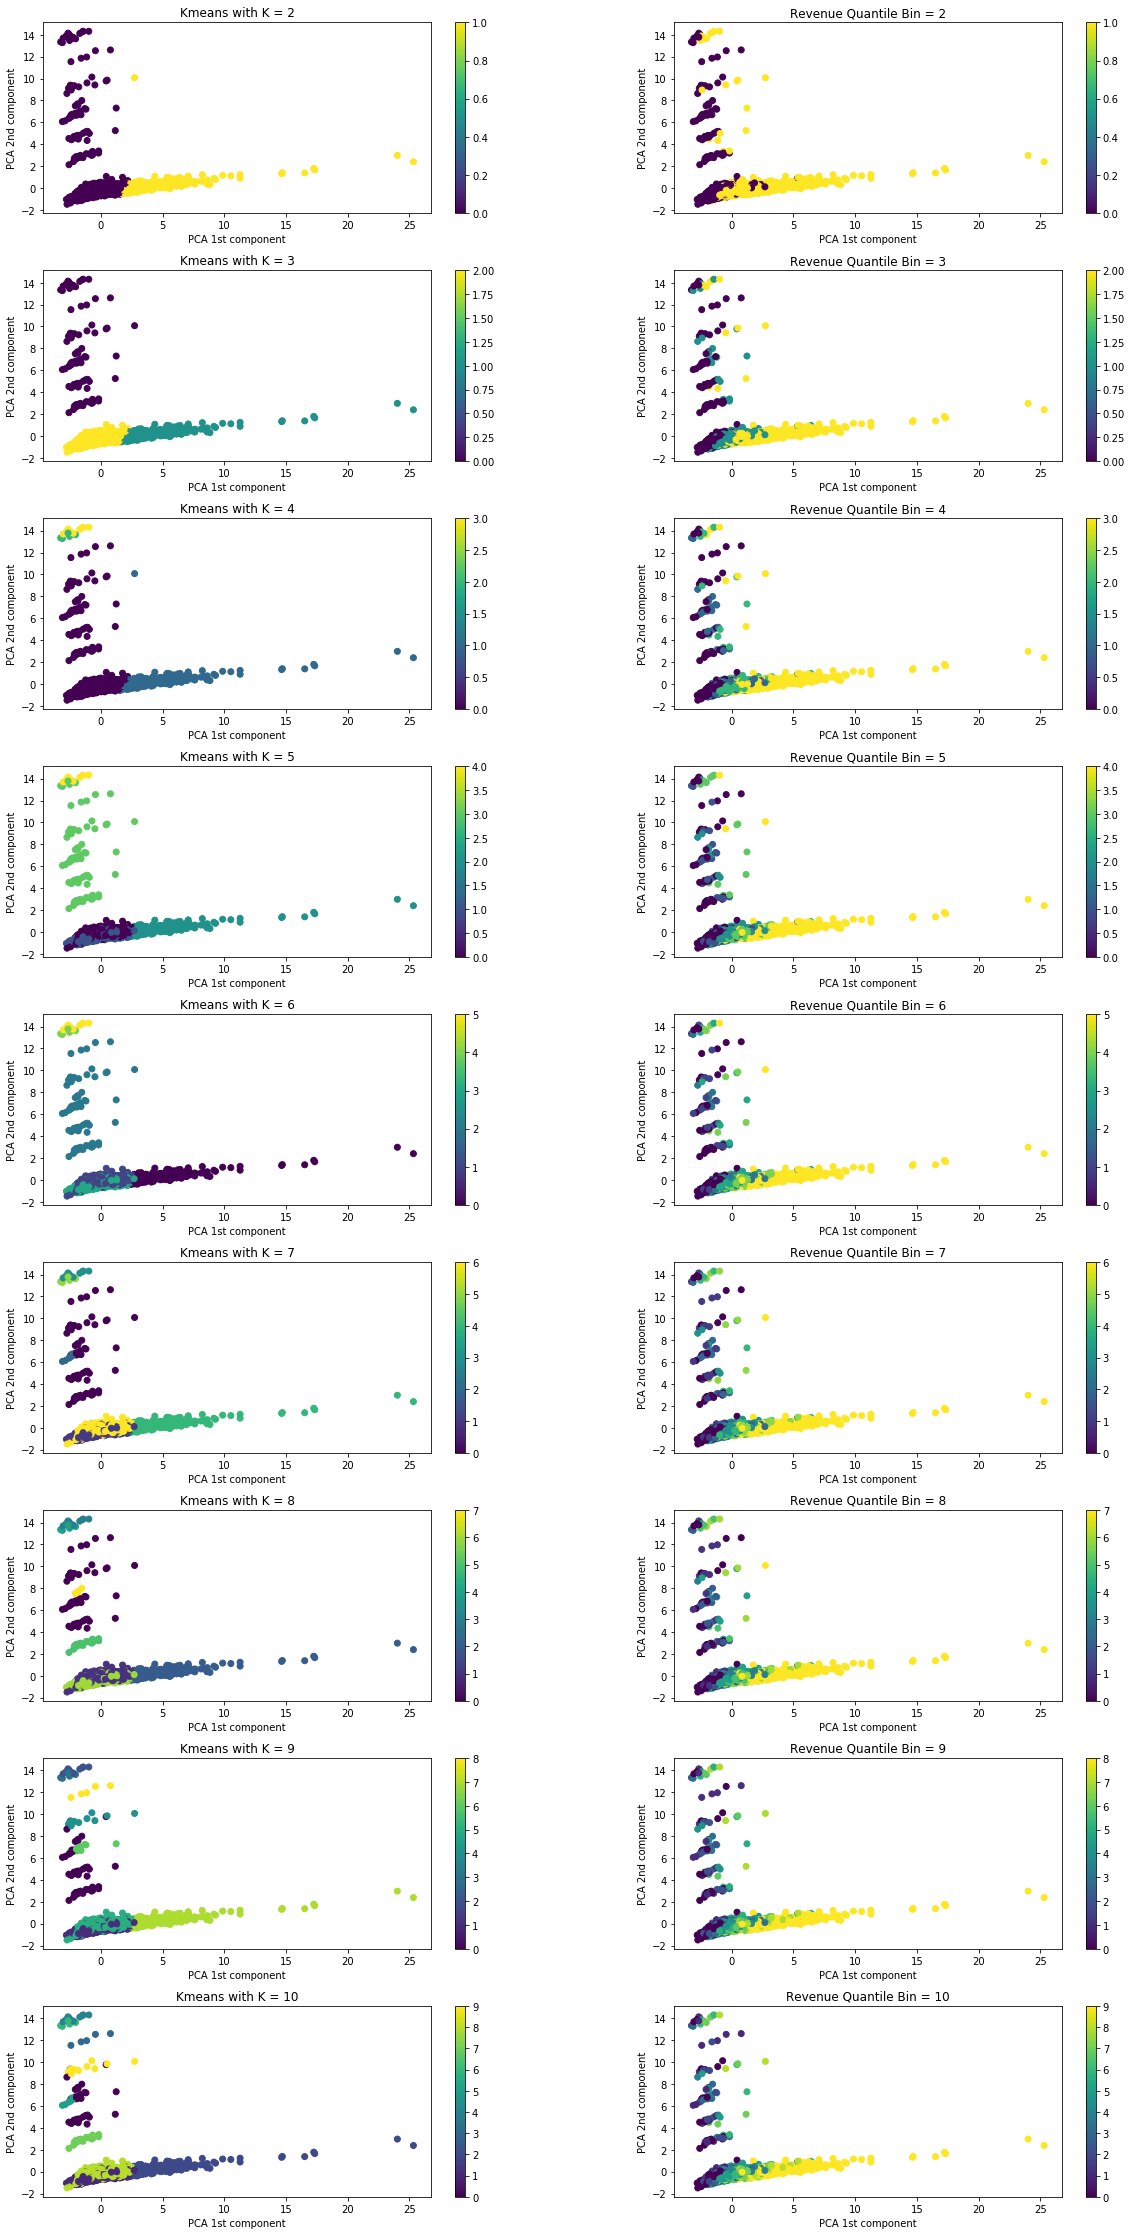

In [4]:
# see the difference with different K without ensemble learning on training data

max_k = 10

pca = PCA(n_components=5)
np_pca = pca.fit_transform(X_train)
display(pca.explained_variance_ratio_)
fig, axs = plt.subplots(max_k - 1, 2, figsize=(20, 40))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=i, random_state=1)
    cluster_predict = kmeans.fit_predict(X_train)

    df_pca = pd.DataFrame(data=np_pca[:, :2], columns=['pca_1st_col', 'pca_2nd_col'], index=X_train.index)
    
    df_pca['revenue'] = X_train['revenue']
    df_pca['revenue_bin'] = pd.qcut(X_train['revenue'], i)
    df_pca['revenue_bin_label'] = pd.qcut(X_train['revenue'], i, labels=[*range(i)])
    df_pca['cluster'] = cluster_predict    
   
    axs[i-2, 0].set_ylabel('PCA 2nd component')
    axs[i-2, 0].set_xlabel('PCA 1st component')
    axs[i-2, 0].set_title(f'Kmeans with K = {i}')
    f1 = axs[i-2, 0].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['cluster'], cmap='viridis')
    fig.colorbar(f1, ax=axs[i-2, 0])


    axs[i-2, 1].set_ylabel('PCA 2nd component')
    axs[i-2, 1].set_xlabel('PCA 1st component')
    axs[i-2, 1].set_title(f'Revenue Quantile Bin = {i}')
    f2 = axs[i-2, 1].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['revenue_bin_label'], cmap='viridis')
    fig.colorbar(f2, ax=axs[i-2, 1])
    
fig.show()

array([0.16980045, 0.12000021, 0.08714986, 0.06160921, 0.05744346])

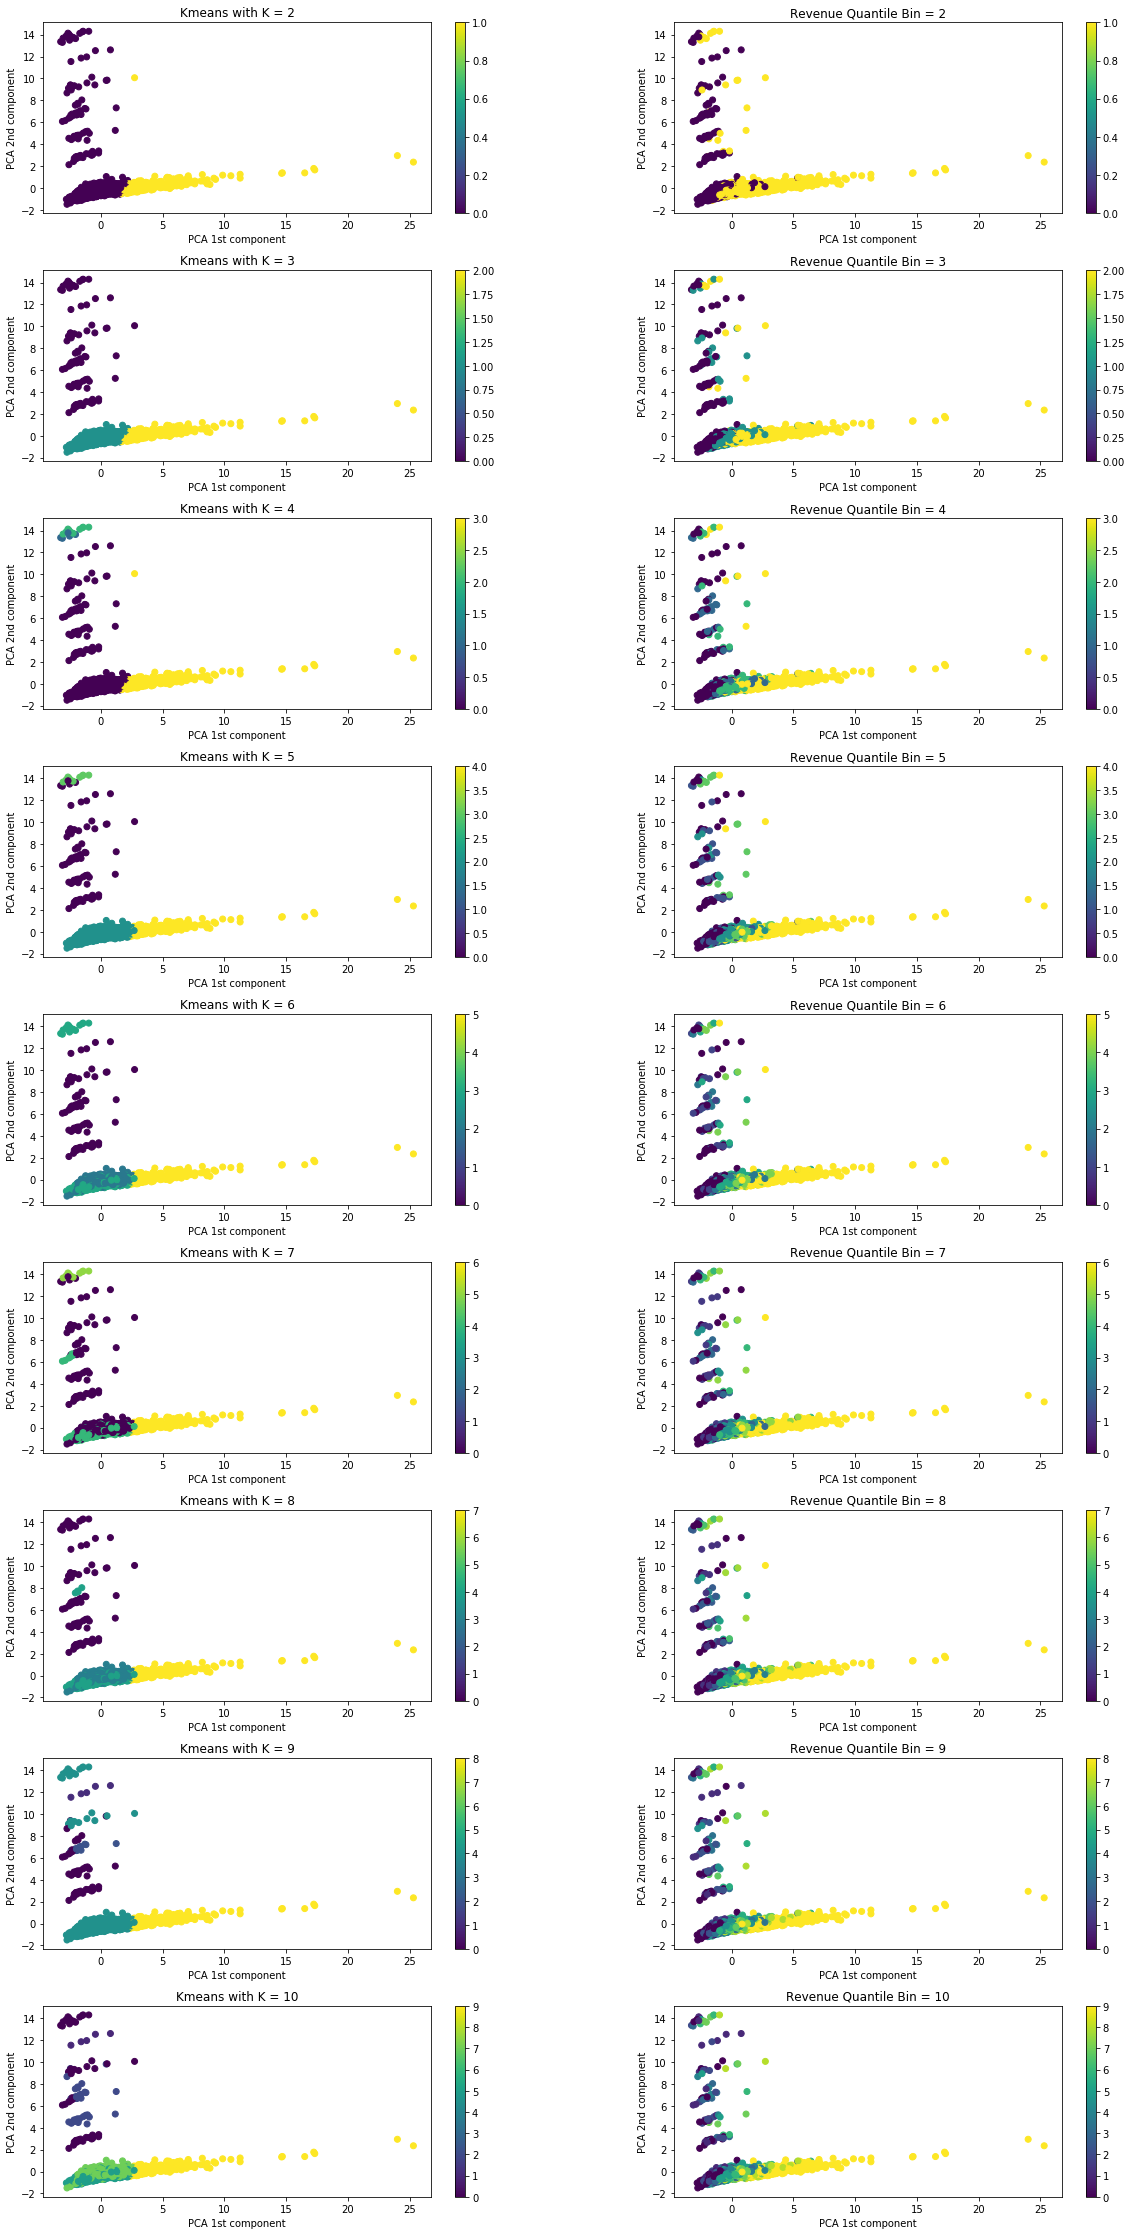

In [5]:
# see the difference with different K with ensemble learning on training data

max_k = 10

pca = PCA(n_components=5)
np_pca = pca.fit_transform(X_train)
display(pca.explained_variance_ratio_)
fig, axs = plt.subplots(max_k - 1, 2, figsize=(20, 40))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

models_store = {
    'pca': pca,
    'kmeans': [],
    'dt': [],
    'bins': [],
}

train_data_save = {
    'y_train': [],
    'X_train': [],
}

for i in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=i, random_state=1)
    cluster_predict = kmeans.fit_predict(X_train)
    
    models_store['kmeans'].append(kmeans)

    df_pca = pd.DataFrame(data=np_pca[:, :2], columns=['pca_1st_col', 'pca_2nd_col'], index=X_train.index)
    
    df_pca['revenue'] = X_train['revenue']
    ser, bins = pd.qcut(X_train['revenue'], i, retbins=True, labels=[*range(i)])
    df_pca['revenue_bin_label'] = ser
    df_pca['cluster'] = cluster_predict
    
    models_store['bins'].append(bins)

    # predict cluster actual label
    clf = DecisionTreeClassifier(max_depth=3, random_state=1)
    clf.fit(df_pca[['cluster']], df_pca[['revenue_bin_label']])
    df_pca['cluster_pred'] = clf.predict(df_pca[['cluster']])
    train_data_save['y_train'].append(df_pca[['revenue_bin_label']])
    train_data_save['X_train'].append(df_pca[['cluster']])
    models_store['dt'].append(clf)
   
    axs[i-2, 0].set_ylabel('PCA 2nd component')
    axs[i-2, 0].set_xlabel('PCA 1st component')
    axs[i-2, 0].set_title(f'Kmeans with K = {i}')
    f1 = axs[i-2, 0].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['cluster_pred'], cmap='viridis')
    fig.colorbar(f1, ax=axs[i-2, 0])


    axs[i-2, 1].set_ylabel('PCA 2nd component')
    axs[i-2, 1].set_xlabel('PCA 1st component')
    axs[i-2, 1].set_title(f'Revenue Quantile Bin = {i}')
    f2 = axs[i-2, 1].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['revenue_bin_label'], cmap='viridis')
    fig.colorbar(f2, ax=axs[i-2, 1])
    
    
    
fig.show()

array([0.16980045, 0.12000021, 0.08714986, 0.06160921, 0.05744346])

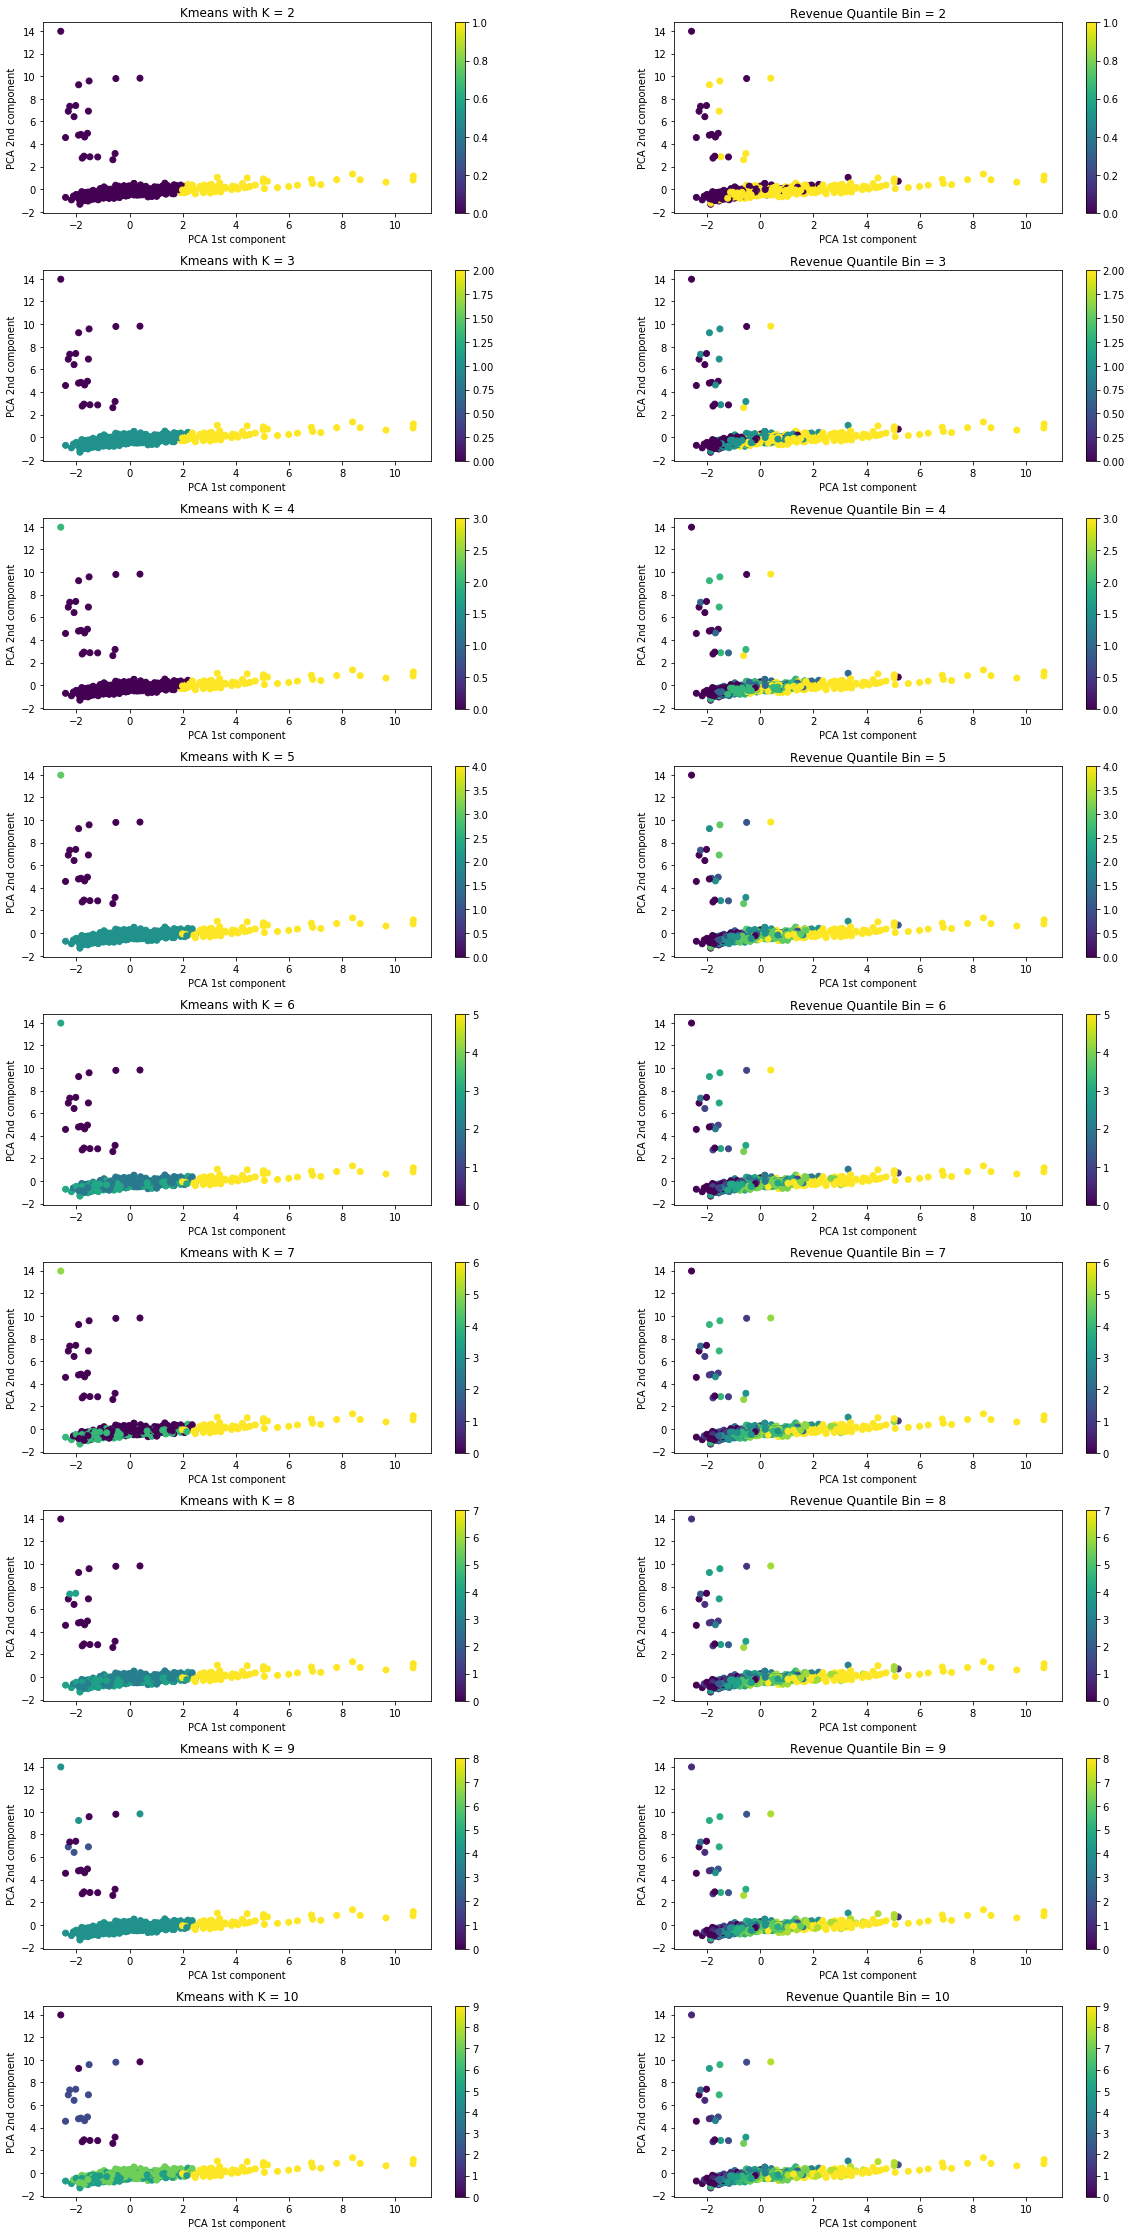

In [6]:
# see the difference with different K with ensemble learning on testing data

max_k = 10

pca = models_store['pca']
np_pca = pca.transform(X_test)
display(pca.explained_variance_ratio_)
fig, axs = plt.subplots(max_k - 1, 2, figsize=(20, 40))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

test_data_save = {
    'y_pred': [],
    'y_true': [],
}

for i in range(2, max_k + 1):
    kmeans = models_store['kmeans'][i - 2]
    cluster_predict = kmeans.predict(X_test)
    
    df_pca = pd.DataFrame(data=np_pca[:, :2], columns=['pca_1st_col', 'pca_2nd_col'], index=X_test.index)
    
    df_pca['revenue'] = X_test['revenue']
    bins = models_store['bins'][i - 2]
    ser = pd.cut(X_test['revenue'], bins=bins, labels=[*range(i)])
    df_pca['revenue_bin_label'] = ser
    df_pca['cluster'] = cluster_predict
    
    test_data_save['y_pred'].append(cluster_predict)
    test_data_save['y_true'].append(ser)
        
    # predict cluster actual label
    clf = models_store['dt'][i - 2]
    df_pca['cluster_pred'] = clf.predict(df_pca[['cluster']])
   
    axs[i-2, 0].set_ylabel('PCA 2nd component')
    axs[i-2, 0].set_xlabel('PCA 1st component')
    axs[i-2, 0].set_title(f'Kmeans with K = {i}')
    f1 = axs[i-2, 0].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['cluster_pred'], cmap='viridis')
    fig.colorbar(f1, ax=axs[i-2, 0])


    axs[i-2, 1].set_ylabel('PCA 2nd component')
    axs[i-2, 1].set_xlabel('PCA 1st component')
    axs[i-2, 1].set_title(f'Revenue Quantile Bin = {i}')
    f2 = axs[i-2, 1].scatter(df_pca['pca_1st_col'], df_pca['pca_2nd_col'], c=df_pca['revenue_bin_label'], cmap='viridis')
    fig.colorbar(f2, ax=axs[i-2, 1])
    
    
    
fig.show()

In [7]:
display(np.array(test_data_save['y_true']).shape)
display(np.array(test_data_save['y_pred']).shape)

(9, 634)

(9, 634)

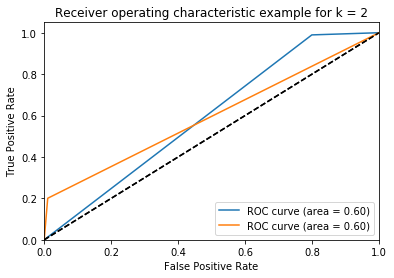

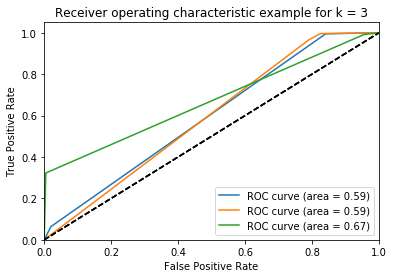

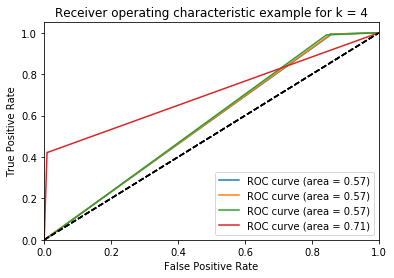

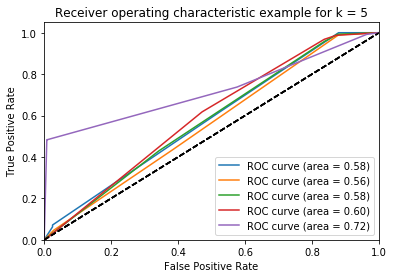

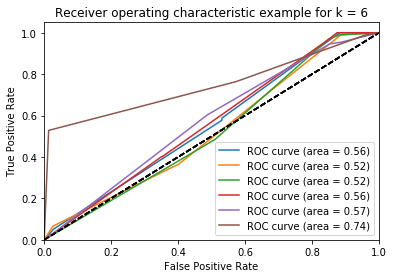

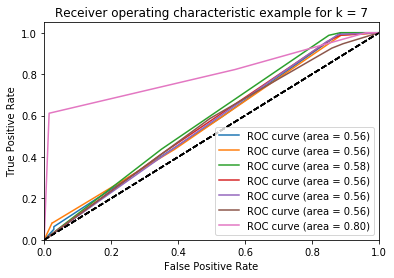

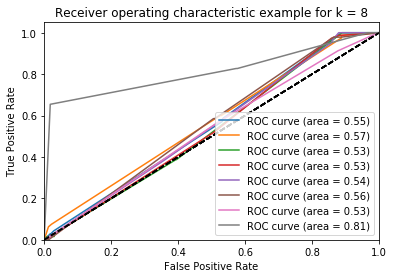

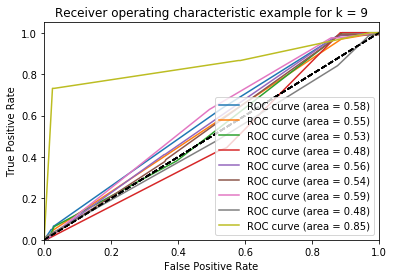

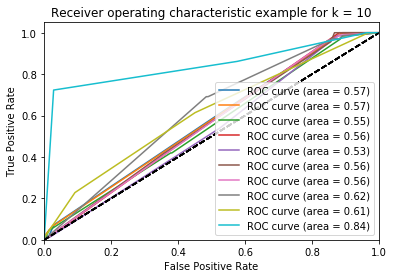

In [8]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

for k in range(2, max_k + 1):
    n_classes = k
    
    y_test = np.array(test_data_save['y_true'][k - 2]).reshape(-1, 1)
    y_train = np.array(train_data_save['y_train'][k - 2]).reshape(-1, 1)
    X_train = np.array(train_data_save['X_train'][k - 2]).reshape(-1, 1)
    X_test = np.array(test_data_save['y_pred'][k - 2]).reshape(-1, 1)

    if k == 2:
        y_test = label_binarize(y_test, classes=[0, 1, 2])
    else:
        y_test = label_binarize(y_test, classes=[*range(k)])

    # classifier
    clf = OneVsRestClassifier(estimator=models_store['dt'][k - 2])
    y_score = clf.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver operating characteristic example for k = {k}')
        plt.legend(loc="lower right")
    plt.show()